In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import xgboost as xgb

import shap 
from sklearn.feature_selection import mutual_info_classif

In [2]:
df = pd.read_csv('C:/Users/kisha/Documents/Uni-Stuff/Dissertation/books/git/data_cleaned.csv')

In [3]:
df.describe()

,Winner,title_bout,no_of_rounds,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,...,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,R_Height_cms,R_Reach_cms,R_Weight_lbs,B_age,R_age
count,7353.000000,7353.000000,7353.000000,7353.000000,7353.000000,7353.000000,7353.000000,7353.000000,7353.000000,7353.00000,...,7353.000000,7353.000000,7353.000000,7353.000000,7353.000000,7353.000000,7353.000000,7353.000000,7353.000000,7353.000000
mean,0.357813,0.056032,3.177751,0.202262,0.141200,0.461754,0.443490,0.269510,0.249192,0.37402,...,0.350333,1.423637,1.402557,0.853393,0.065279,178.491220,183.106952,167.319325,29.588059,29.988032
std,0.479389,0.229998,0.587395,0.341451,0.299667,0.112259,0.113127,0.237587,0.232641,0.62102,...,0.660722,1.850116,1.934328,1.472820,0.267140,9.022199,10.823690,35.283610,4.033949,4.231067
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,152.400000,147.320000,115.000000,18.000000,18.000000
25%,0.000000,0.000000,3.000000,0.000000,0.000000,0.408906,0.386541,0.080000,0.075000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,172.720000,175.260000,145.000000,27.000000,27.000000
50%,0.000000,0.000000,3.000000,0.031250,0.000000,0.460000,0.440000,0.229492,0.196641,0.12500,...,0.000000,1.000000,1.000000,0.000000,0.000000,177.800000,182.880000,155.000000,29.000000,30.000000
75%,1.000000,0.000000,3.000000,0.257812,0.125000,0.513672,0.496250,0.387500,0.330408,0.50000,...,1.000000,2.000000,2.000000,1.000000,0.000000,185.420000,190.500000,185.000000,32.000000,33.000000
max,1.000000,1.000000,5.000000,5.000000,4.000000,1.000000,1.000000,1.000000,1.000000,8.00000,...,5.000000,11.000000,14.000000,16.000000,2.000000,210.820000,213.360000,345.000000,51.000000,47.000000


In [5]:
X = df.drop(columns=['Winner'])
y = df['Winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

scaler = StandardScaler()

#addressing class imbalance with smote
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


First we try with xgboost

In [6]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {xgb_accuracy}")

XGBoost Accuracy: 0.6267845003399048


In [7]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'alpha': [0, 0.5, 1],
    'lambda': [1, 1.5, 2]
}

In [8]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score}")

Fitting 5 folds for each of 2916 candidates, totalling 14580 fits
Best Parameters: {'alpha': 0.5, 'colsample_bytree': 0.8, 'lambda': 1.5, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.6}
Best Cross-Validation Accuracy: 0.7368920588303849


In [9]:
best_xgb_model = grid_search.best_estimator_
y_pred_best_xgb = best_xgb_model.predict(X_test)
best_xgb_accuracy = accuracy_score(y_test, y_pred_best_xgb)
print(f"XGBoost Accuracy with Best Parameters: {best_xgb_accuracy}")

XGBoost Accuracy with Best Parameters: 0.6346023113528212


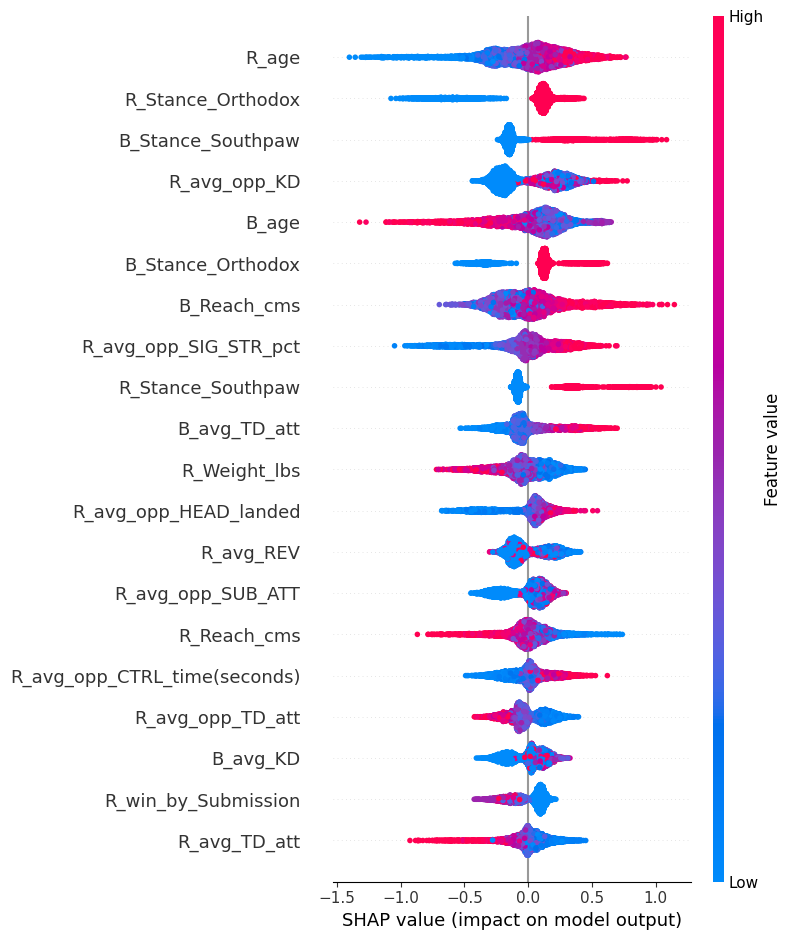

In [10]:
explainer_xgb = shap.Explainer(best_xgb_model)
shap_values_xgb = explainer_xgb(X_train)
shap.summary_plot(shap_values_xgb, X_train, feature_names=X.columns)


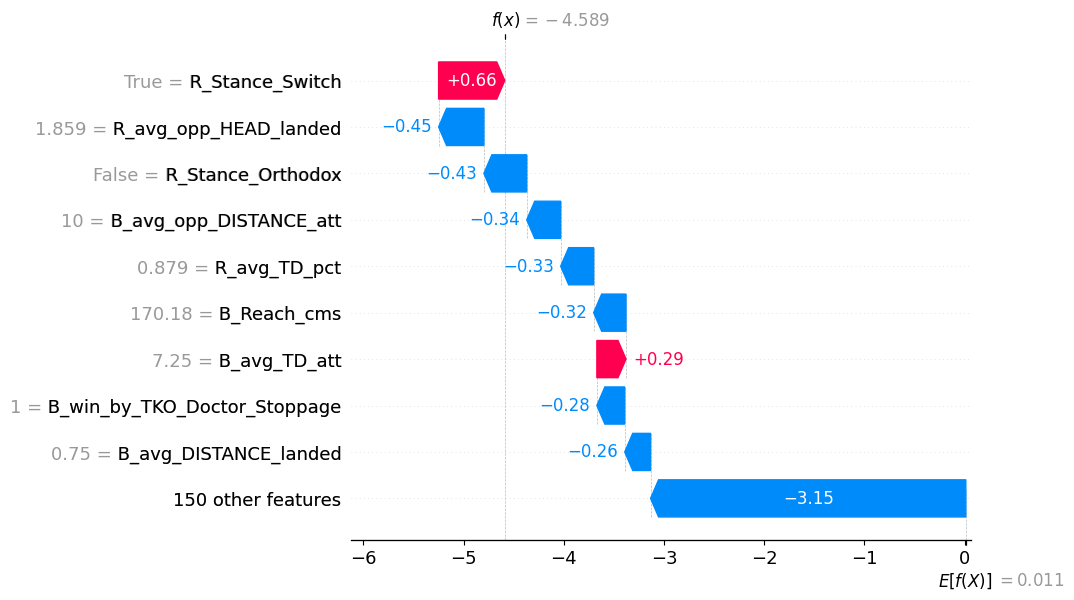

In [11]:
#waterfall plot for shap values

shap.plots.waterfall(shap_values_xgb[78])


In [12]:
#force plot for shap values

shap.plots.force(shap_values_xgb[0])

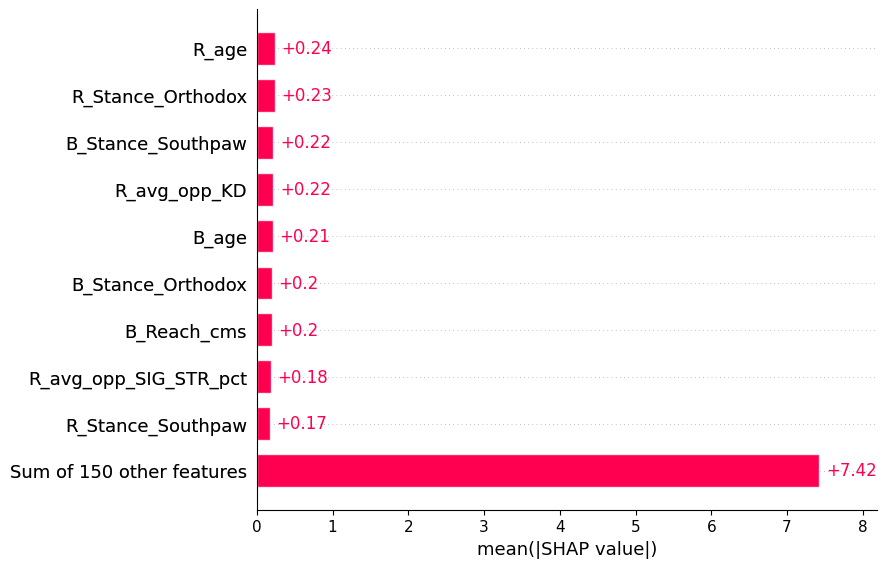

In [13]:
shap.plots.bar(shap_values_xgb)

In [14]:
shap_values_xgb

.values =
array([[ 0.00752022, -0.01979368,  0.21161427, ...,  0.13601734,
        -0.07095954, -0.05724847],
       [ 0.00457554, -0.01572395, -0.19254492, ...,  0.06878065,
        -0.09141722, -0.03720923],
       [ 0.00783347, -0.00938557,  0.21504563, ...,  0.13072187,
        -0.09922557, -0.02716187],
       ...,
       [ 0.00492798, -0.00581507, -0.14068922, ...,  0.09309994,
        -0.06918626,  0.71728027],
       [ 0.00597988, -0.00499072,  0.11661435, ...,  0.13151433,
        -0.07860185, -0.04273896],
       [ 0.00346437, -0.00586902,  0.13035777, ...,  0.35412243,
         0.7343706 , -0.02862345]], dtype=float32)

.base_values =
array([0.01141684, 0.01141684, 0.01141684, ..., 0.01141684, 0.01141684,
       0.01141684], dtype=float32)

.data =
array([[0, 3, 0.28125, ..., True, False, False],
       [0, 3, 6.1e-05, ..., True, False, False],
       [0, 3, 0.508789063, ..., True, False, False],
       ...,
       [0, 3, 0.0, ..., True, False, True],
       [0, 3, 1.2269353

In [15]:
mi = mutual_info_classif(X, y)
mi_series = pd.Series(mi, index=X.columns)
mi_series = mi_series.sort_values(ascending=False)
print(mi_series)

R_avg_opp_HEAD_att           0.021092
R_avg_opp_SIG_STR_landed     0.019377
B_avg_SIG_STR_landed         0.017846
R_avg_SUB_ATT                0.017804
R_avg_opp_DISTANCE_landed    0.017351
                               ...   
B_avg_opp_CLINCH_att         0.000000
R_avg_opp_LEG_att            0.000000
B_avg_CLINCH_att             0.000000
B_avg_opp_LEG_att            0.000000
R_Stance_Switch              0.000000
Length: 159, dtype: float64


In [16]:
mi_series.head(20)

R_avg_opp_HEAD_att              0.021092
R_avg_opp_SIG_STR_landed        0.019377
B_avg_SIG_STR_landed            0.017846
R_avg_SUB_ATT                   0.017804
R_avg_opp_DISTANCE_landed       0.017351
B_avg_opp_BODY_att              0.015968
R_avg_opp_TOTAL_STR_att         0.015465
no_of_rounds                    0.015190
R_avg_opp_TD_pct                0.015136
R_avg_BODY_att                  0.014708
R_Weight_lbs                    0.014706
B_avg_opp_DISTANCE_landed       0.014589
R_avg_opp_SIG_STR_pct           0.014217
R_wins                          0.012885
R_avg_opp_CTRL_time(seconds)    0.012727
B_avg_HEAD_landed               0.012281
R_total_rounds_fought           0.012058
R_avg_SIG_STR_pct               0.011809
B_avg_DISTANCE_att              0.011728
B_avg_opp_TD_landed             0.011632
dtype: float64

<Axes: >

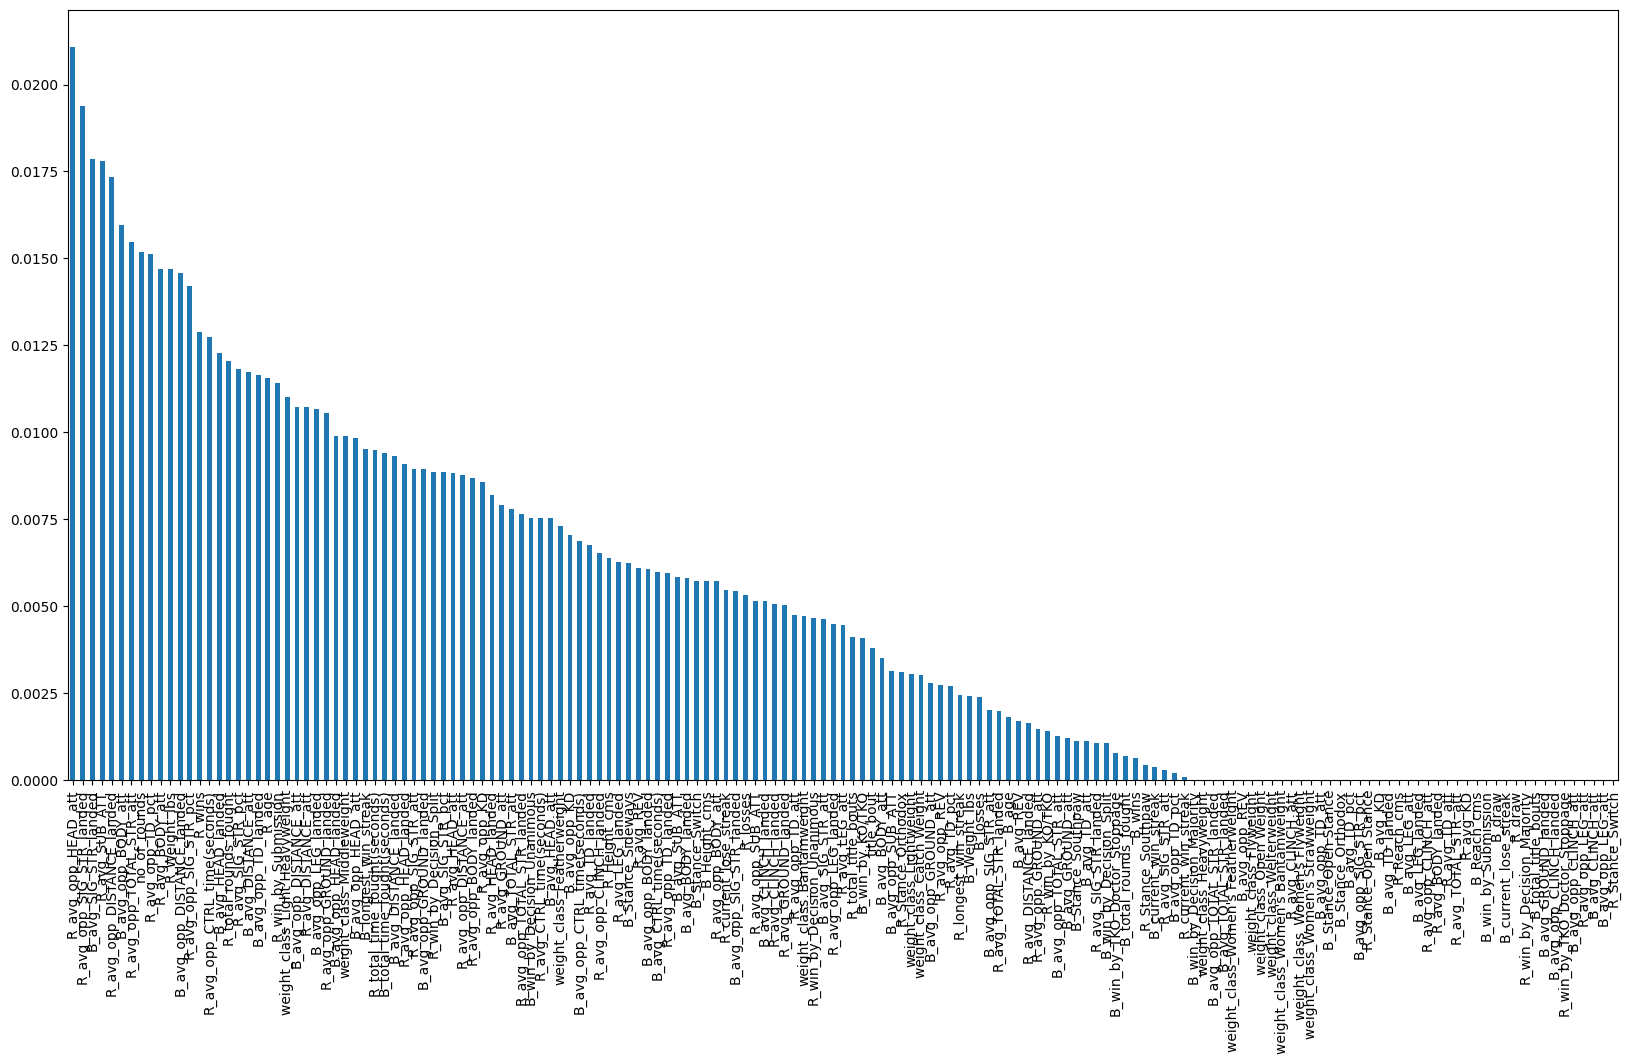

In [17]:
mi_series.plot.bar(figsize=(20, 10))


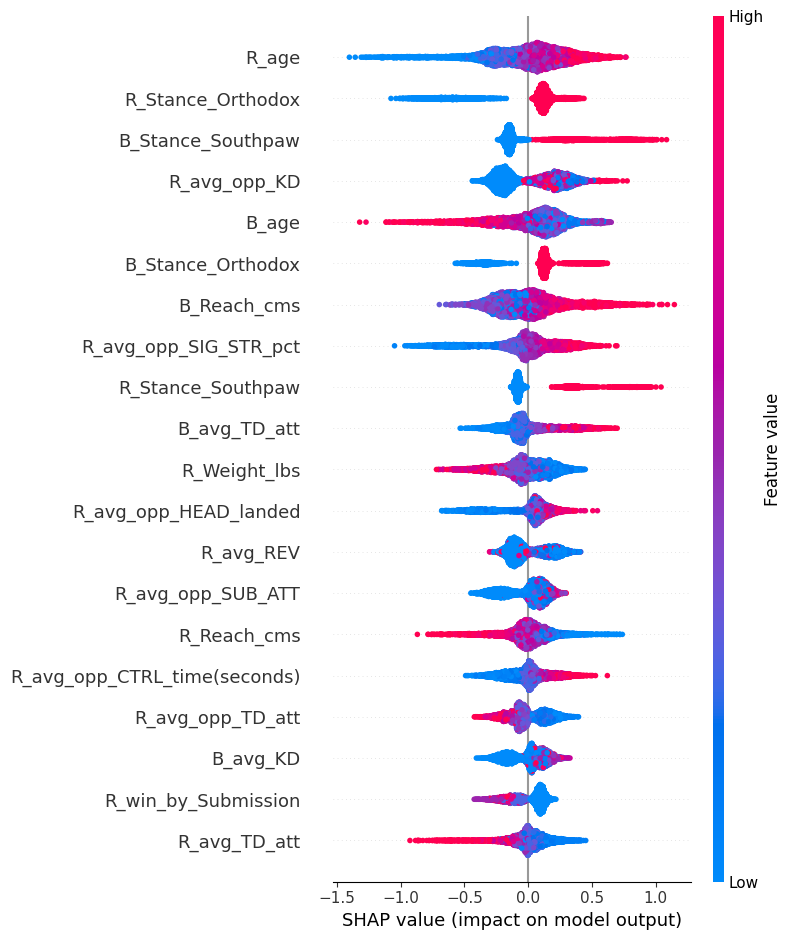

In [20]:
explainer_xgb = shap.Explainer(best_xgb_model)
shap_values_xgb = explainer_xgb(X_train)
shap.summary_plot(shap_values_xgb, X_train, feature_names=X.columns)


In [22]:
#test train split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

#class imbalance : undersampling majority class

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

#scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#PCA

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

KMeans Accuracy: 0.5904146838885113


Text(0.5, 1.0, 'KMeans Confusion Matrix')

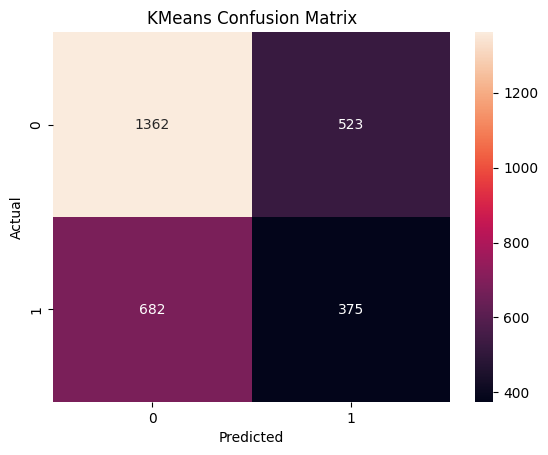

In [23]:
#kmeans

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_pca)

#predict and evaluate

y_pred_kmeans = kmeans.predict(X_test_pca)
kmeans_accuracy = accuracy_score(y_test, y_pred_kmeans)
print(f"KMeans Accuracy: {kmeans_accuracy}")

#confusion matrix

cm_kmeans = confusion_matrix(y_test, y_pred_kmeans)
sns.heatmap(cm_kmeans, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KMeans Confusion Matrix')


In [24]:
#XGB

xgb_model1 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model1.fit(X_train_pca, y_train)

#Predict and evaluate
y_pred_xgb1 = xgb_model1.predict(X_test_pca)
xgb_accuracy1 = accuracy_score(y_test, y_pred_xgb1)
print(f"XGBoost Accuracy: {xgb_accuracy1}")



XGBoost Accuracy: 0.5720598232494901


Text(0.5, 1.0, 'XGBoost Confusion Matrix')

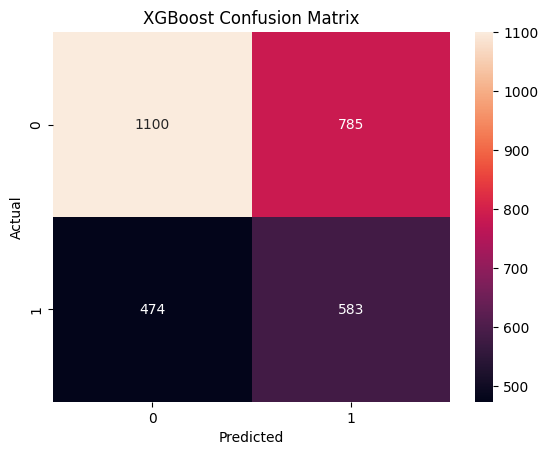

In [26]:
#confusion matrix

cm_xgb = confusion_matrix(y_test, y_pred_xgb1)
sns.heatmap(cm_xgb, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')



In [25]:
#logistic regression

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred_log_reg = log_reg.predict(X_test_pca)
log_reg_accuracy = accuracy_score(y_test, y_pred_log_reg)
print(f"Logistic Regression Accuracy: {log_reg_accuracy}")


Logistic Regression Accuracy: 0.6108089734874235


In [27]:
#gaussian naive bayes

from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred_gnb = gnb.predict(X_test_pca)
gnb_accuracy = accuracy_score(y_test, y_pred_gnb)
print(f"Gaussian Naive Bayes Accuracy: {gnb_accuracy}")

Gaussian Naive Bayes Accuracy: 0.5363698164513936


In [28]:
#svm

from sklearn.svm import SVC

svm = SVC(random_state=42)
svm.fit(X_train_pca, y_train)

# Predict and evaluate

y_pred_svm = svm.predict(X_test_pca)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Accuracy: {svm_accuracy}")

SVM Accuracy: 0.6148878314072059


In [29]:
#oversampling minority class

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

#scaling

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#PCA

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)




In [30]:
#XGB

xgb_model2 = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model2.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred_xgb2 = xgb_model2.predict(X_test_pca)
xgb_accuracy2 = accuracy_score(y_test, y_pred_xgb2)
print(f"XGBoost Accuracy: {xgb_accuracy2}")


XGBoost Accuracy: 0.5720598232494901
